In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from typing import Tuple
import numpy as np
import argparse
import random
import os, sys
import torch.distributed as dist

import torchvision.transforms as transforms
import torch.nn.functional as F

from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import sys
from torch.utils.data import Dataset
import pickle

In [2]:
PROJECT_DIR = '/home/ubuntu/Documents/mtDGX'

sys.path.append(os.path.realpath(f"{PROJECT_DIR}/captum"))
sys.path.append(os.path.realpath(f"{PROJECT_DIR}/LLaMA_VQA"))
sys.path.append(os.path.realpath(f"{PROJECT_DIR}/LLaMA_VQA/utils"))
sys.path.append(os.path.abspath(f"{PROJECT_DIR}/LLaMA_VQA/utils"))

from captum.attr import (
    IntegratedGradients,
    LayerIntegratedGradients,
    TokenReferenceBase,
    configure_interpretable_embedding_layer,
    remove_interpretable_embedding_layer,
    visualization
)
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load pretrained model

In [3]:

from LLaMA_VQA.PVQAmodel import PVQAmodel

def set_random_seeds(random_seed=0):
    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

def parse_argument():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_type", type=str, default="tiny-llama", choices=("llama2", "gpt2-xl", "microsoft/biogpt","stanford-crfm/BioMedLM"))
    parser.add_argument("--notes", type=str, default="exp0")
    parser.add_argument("--question_type", type=str, default="oa", choices=("oa", "closed"))
    parser.add_argument("--setting", type=str, default="lora", choices=("lora", "frozen",'prefixtuning',"p_tuning","prompttuning", "unfrozen"))
    parser.add_argument("--ablation", type=str, default="none", choices=("remove_question", "remove_visual",'replace_visual',"swap"))
    parser.add_argument("--mapping_type", type=str, default="MLP")
    parser.add_argument("--prefix_length", type=int, default=6)
    parser.add_argument("--dataset_path", type=str, default="data/")
    parser.add_argument("--batch_size", type=int, default=6)
    parser.add_argument("--epochs", type=int, default=1)
    parser.add_argument("--dataset", type=str, default='pvqa/CLIPLLAMA', choices=('pvqa/CLIPGPT2', 'pvqa/CLIPLLAMA', 'pathvqa', 'ovqa', 'slake'))
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--warmup_steps", type=int, default=600)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--iters_to_accumulate", type=int, default=4)
    parser.add_argument("--validation_step", type=int, default=1000)
    parser.add_argument("--out_dir", default="data/model-outputs/checkpoints")
    parser.add_argument("--checkpoint", type=str)
    parser.add_argument("--eval", dest="eval", action="store_true")
    parser.add_argument("--verbose", dest="verbose", action="store_true")
    parser.add_argument("--early_stopping", type=bool, default=True)
    parser.add_argument("--tqdm", type=bool, default=False)
    parser.add_argument("--like_test", type=bool, default=False)
    
    parser.add_argument("--wandb", type=bool, default=False)
    # Add distributed training arguments
    parser.add_argument("--local_rank", type=int, default=0)
    parser.add_argument("--world_size", type=int, default=1)  # Total number of processes
    parser.add_argument("--rank", type=int, default=0)  # Rank of the current process
    parser.add_argument("--nodes", type=int, default=0)
    parser.add_argument("--gpus_per_node", type=int, default=torch.cuda.device_count())  # GPUs per node
    parser.add_argument("--num_workers", type=int, default=0)
    args, _ = parser.parse_known_args()
    set_random_seeds(args.seed)
    return args


def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '8500'
    dist.init_process_group("nccl", rank=rank, world_size=world_size) # try gloo


def cleanup():
    dist.destroy_process_group()


In [4]:
args = parse_argument() 
setup(rank=args.rank, world_size=args.world_size)

In [5]:
# args.notes = "th_3_tiny_p12"
# args.model_type = "tiny-llama"
# args.lr = 1e-4
# args.prefix_length = 12

args.notes = "th_2_llama_lr5"
args.model_type = "llama2"
args.lr = 1e-5
args.prefix_length = 6

pvqamodel = PVQAmodel(args)

pvqamodel.model.eval()

Configured cuda:0.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded model from the checkpoint at epoch 60.
Model successfully loaded.


VQAmedModel(
  (peftmodel): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): LlamaForCausalLM(
        (model): LlamaModel(
          (embed_tokens): Embedding(32000, 4096, padding_idx=0)
          (layers): ModuleList(
            (0-31): 32 x LlamaDecoderLayer(
              (self_attn): LlamaAttention(
                (q_proj): Linear8bitLt(
                  in_features=4096, out_features=4096, bias=False
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=4096, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=8, out_features=4096, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                  (lora_embedding_B): ParameterDict()
                )
                (k_proj): Lin

In [6]:
USE_INTEPRETABLE_EMBEDDING_LAYER = True
interpretable_embedding = configure_interpretable_embedding_layer(pvqamodel, 'model.peftmodel.base_model.model.model.embed_tokens')



/home/ubuntu/Documents/mtDGX/captum/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [7]:
# remove_interpretable_embedding_layer(pvqamodel, interpretable_embedding)

In [7]:
image_size = 224  # scale image to given size and center
central_fraction = 1.0

PAD_IND = pvqamodel.model.tokenizer.pad_token_id
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
torch.backends.cudnn.enabled=False



In [8]:
import clip
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)


Helper functions for interpretability: image_features needed which vome before embeddings. forward hook needed.

In [9]:
def get_image_feature(img):
    img_features = preprocess(img)
    return img_features.unsqueeze(0)

def forward_func(img_features, embedding, mask, q_len): 
    prefix = clip_model.encode_image(img_features.to(device)) # torch.Size([1, 512])   
    prefix = prefix.type(torch.float32).to(device)
    # embedding = embedding.detach()
    # print(prefix.shape) # n=2:torch.Size([2, 512]) n=1:torch.Size([1, 512])
    # print(pvqamodel.model.prefix_length) # 12
    # mat1 and mat2 shapes cannot be multiplied (1x1024 and 512x12288)
    # print(prefix.view(1, -1).shape) # n=2:torch.Size([1, 1024]) n=1:torch.Size([1, 512])
    # prefix_projections = pvqamodel.model.clip_project(prefix.view(1, -1)).view(pvqamodel.model.prefix_length, pvqamodel.model.base_model_embedding_size)#.to(self.device)

    prefix_projections = pvqamodel.model.clip_project(prefix).view(-1,pvqamodel.model.prefix_length, pvqamodel.model.base_model_embedding_size)#.to(self.device)
    # print(prefix_projections.shape) # n=1:torch.Size([12, 2048]) torch.Size([24, 2048])
    # embedding = embedding.squeeze(0) # emb torch.Size([1, 28, 2048]) before squeeze
    # print(embedding.shape) # torch.Size([2, 28, 2048])
    # print(prefix_projections.shape) # torch.Size([2, 12, 2048])
    for b in range(embedding.shape[0]):
        # print(embedding[0].shape) # torch.Size([28, 2048])
        embedding[b,q_len:q_len+pvqamodel.model.prefix_length,:] = prefix_projections[b]
    # print(embedding.shape) # torch.Size([2, 28, 2048])
    # The size of tensor a (2048) must match the size of tensor b (57344) at non-singleton dimension 2
    # embed = embedding.view(1, embedding.size(0), -1)

    outputs = pvqamodel.model.peftmodel(inputs_embeds=embedding,output_attentions=True)
    # return outputs
    logits = outputs.logits
    logits = logits[:, -1, :] 
    logits = logits.softmax(-1).log() 
    return logits # torch.Size([1, 32001]) or 2 if n=2

def forward_func_1(img_features, embedding, mask, q_len): 
    prefix = clip_model.encode_image(img_features.to(device)) # torch.Size([1, 512])   
    prefix = prefix.type(torch.float32).to(device)
    prefix_projections = pvqamodel.model.clip_project(prefix.view(1, -1)).view(pvqamodel.model.prefix_length, pvqamodel.model.base_model_embedding_size)#.to(self.device)
    embedding = embedding.squeeze(0) # emb torch.Size([1, 28, 2048]) before squeeze

    embedding[q_len:q_len+pvqamodel.model.prefix_length,:] = prefix_projections

    embed = embedding.view(1, embedding.size(0), -1)

    outputs = pvqamodel.model.peftmodel(inputs_embeds=embed,output_attentions=True)
    logits = outputs.logits
    logits = logits[:, -1, :] 
    logits = logits.softmax(-1).log() 
    return logits # torch.Size([1, 32001]) or 2 if n=2

def generate_embedding(prefix, tokens, mask, q_len):
    prefix_projections = pvqamodel.model.clip_project(prefix.view(1, -1)).view(pvqamodel.model.prefix_length, pvqamodel.model.base_model_embedding_size)#.to(self.device)
    # embedding_txt = self.peftmodel.model.embed_tokens.embedding(tokens) 
    embedding_txt = pvqamodel.model.peftmodel.base_model.model.model.embed_tokens.embedding(tokens) 
    embedding_txt[q_len:q_len+pvqamodel.model.prefix_length,:] = prefix_projections
    return embedding_txt.view(1, tokens.size(0), -1) # afterward generate_beam

Debug for iter = 30

# Examples:

In [24]:
def interpret(prefix, tokens, mask, q_len, question, target, filename):
    
    q_input_embedding = interpretable_embedding.indices_to_embeddings(tokens)
    q_reference_indices = token_reference.generate_reference(tokens.shape[0], device=device)
    # q_reference_indices = torch.full_like(tokens, PAD_IND).to(device)
    q_reference_baseline = interpretable_embedding.indices_to_embeddings(q_reference_indices)
    img = Image.open(filename)#.convert('RGB')
    img_features = get_image_feature(img).requires_grad_().to(device)

    inputs = (img_features, q_input_embedding)
    baselines = (img_features * 0.0, q_reference_baseline)  

    output = forward_func(img_features, q_input_embedding, mask, q_len) # torch.Size([1, 32001])
    pred, answer_idx = F.softmax(output, dim=1).data.cpu().max(dim=1)

    embed = generate_embedding(prefix, tokens.squeeze(0), mask, q_len)
    prediction = pvqamodel._generate_beam(generated=embed, entry_length=pvqamodel.test_dataset.max_seqs_len[1], temperature=1, tokenizer=pvqamodel.model.tokenizer)[0].lower().strip()
    
    attr = IntegratedGradients(forward_func)  #,multiply_by_inputs=True
    attributions = attr.attribute(inputs=inputs,
                                        baselines=baselines,
                                        target=answer_idx,
                                        additional_forward_args=(mask,q_len),
                                        # method="riemann_right",
                                        n_steps=10)
    

    # visualize test attributions
    text_attributions_norm = attributions[1].sum(dim=-1).squeeze(0).norm()
    vis_data_records = [visualization.VisualizationDataRecord(
                            attributions[1].sum(dim=-1).squeeze(0) / text_attributions_norm,  # "word_attributions",
                            pred[0].item(), # pred for first token
                            prediction, # str "pred_class",
                            target, # str "true_class",
                            prediction, # str "attr_class" aka pred_class
                            attributions[1].sum(),   #  "attr_score",    
                            pvqamodel.model.tokenizer.decode(tokens.squeeze(0)).split(),
                            # question.split(), # ['What', 'have', 'lost', 'their', 'nuclei?'] # "raw_input_ids",
                            0.0)] # "convergence_score",
    visualization.visualize_text(vis_data_records)

    # visualize image attributions
    original_image = transforms.Compose([transforms.Resize(int(image_size / central_fraction)),
                                    transforms.CenterCrop(image_size), transforms.ToTensor()])(img) 
    original_im_mat = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
    attributions_img = np.transpose(attributions[0].squeeze(0).cpu().detach().numpy(), (1, 2, 0))

    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#252b36'),
                                                  (1, '#000000')], N=256)

    visualization.visualize_image_attr_multiple(attributions_img, original_im_mat, 
                                                ["original_image", "heat_map"], 
                                                ["all", "absolute_value"], 
                                                titles=["Original Image", "Attribution Magnitude"],
                                                cmap=default_cmap,
                                                show_colorbar=True)
    print('Text Contributions: ', attributions[1].sum().item())
    print('Image Contributions: ', attributions[0].sum().item())
    print('Total Contribution: ', attributions[0].sum().item() + attributions[1].sum().item())

    return attr


ew pics: 530, 535, 558, 571, 597, 603, 633, 634, 656, 

473, 723, 756, 1069, 1313, 1347, 1434

In [25]:
dataset = pvqamodel.test_dataset
items = [473, 723, 756, 1069, 1313, 1347] # 1434
file_paths = ['/home/ubuntu/Documents/mtDGX/data/pvqa/images/test/test_0242.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/test/test_0494.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/test/test_0495.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/test/test_0860.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/test/test_0577.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/test/test_0579.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/test/test_0624.jpg']
questions = ['What shows a grey white firm tumour extending irregularly into adjacent breast parenchyma?', 'What is present?', 'What is present ?', 'What is present?', 'Where is this part in the figure?', 'Where is this part in the figure?', 'What are present ?']
answers = ['cut surface', 'cardiovascular', 'cardiovascular', 'cardiovascular', 'endocrine system', 'endocrine system', 'extremities']


473


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
cut surface,the affected area (0.94),the affected area,-149.06,question: What shows a grey white firm tumour extending irregularly into adjacent breast parenchyma? context: answer


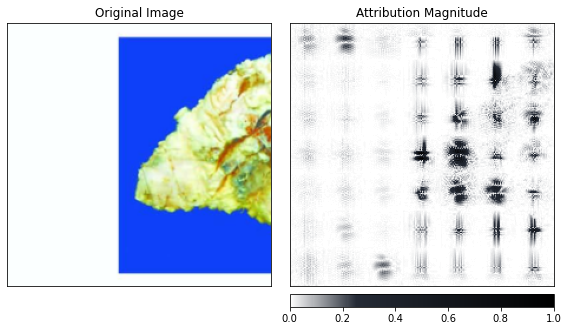

Text Contributions:  -149.06471252441406
Image Contributions:  -3.1795167922973633
Total Contribution:  -152.24422931671143
723


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
cardiovascular,cardiovascular (0.61),cardiovascular,72.87,question: What is present? context: answer


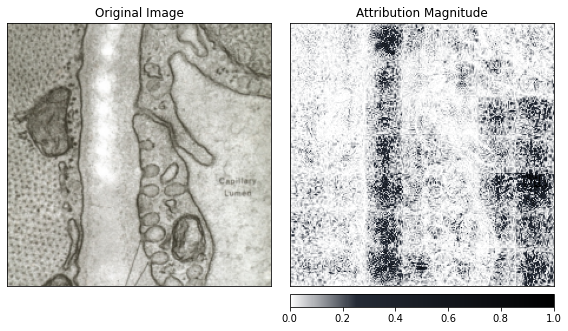

Text Contributions:  72.87086486816406
Image Contributions:  -1.1647720336914062
Total Contribution:  71.70609283447266
756


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Cardiovascular,cardiovascular (0.55),cardiovascular,14.64,question: What is present ? context: answer


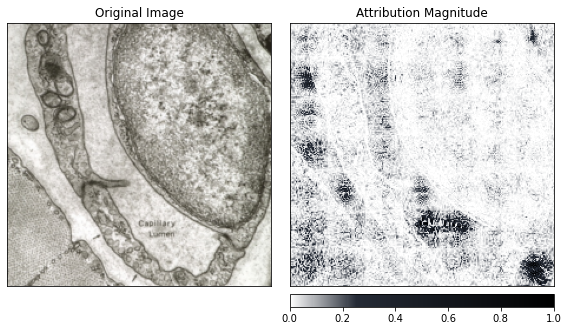

Text Contributions:  14.639392852783203
Image Contributions:  -1.1272815465927124
Total Contribution:  13.51211130619049
1069


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
cardiovascular,cardiovascular (0.79),cardiovascular,70.62,question: What is present? context: answer


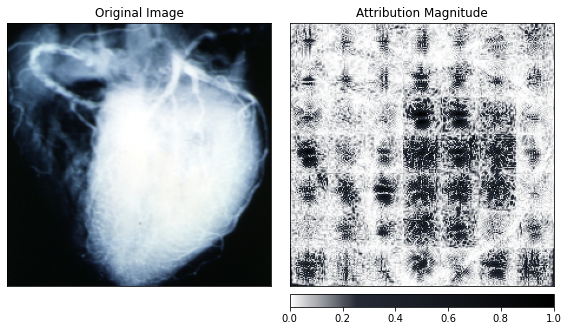

Text Contributions:  70.62018585205078
Image Contributions:  -0.22293519973754883
Total Contribution:  70.39725065231323
1313


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
endocrine system,endocrine system (1.00),endocrine system,67.32,question: Where is this part in the figure? context: answer


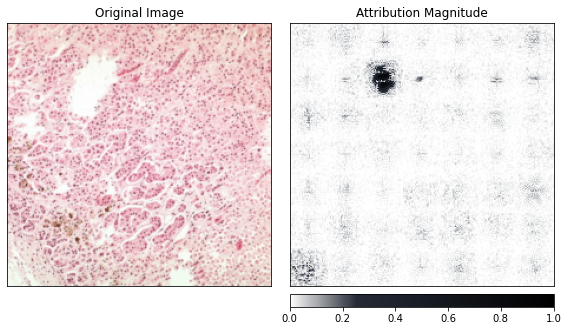

Text Contributions:  67.31961059570312
Image Contributions:  1.2579448223114014
Total Contribution:  68.57755541801453
1347


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
endocrine system,endocrine system (1.00),endocrine system,51.22,question: Where is this part in the figure? context: answer


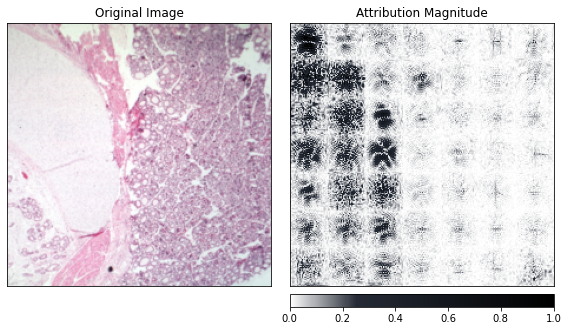

Text Contributions:  51.21918487548828
Image Contributions:  4.265253067016602
Total Contribution:  55.48443794250488


In [26]:
for i in range(len(items)):
    prefix, tokens, mask, q_len = dataset[items[i]]
    prefix = prefix.type(torch.float32).to(device)
    tokens = tokens.type(torch.long).to(device).unsqueeze(0)
    mask = mask.type(torch.long).to(device)
    question = dataset.questions[items[i]]
    target = dataset.answers[items[i]]
    filename = file_paths[i]
    print(items[i])
    interpret(prefix, tokens, mask, q_len, question, target, filename)

GradCam no possible bc this is not a CNN model, so transformers approaches are needed.

In [ ]:
pvqamodel.args.like_test = True
pvqamodel.dev_dataset = pvqamodel._build_dataset("val")
dataset = pvqamodel.dev_dataset
file_paths = ['/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0261.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0261.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0261.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0178.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0178.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0178.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0178.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0178.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0178.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0202.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0202.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0174.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0174.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0174.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0119.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0119.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0121.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0121.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0150.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0150.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0150.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0150.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0115.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0115.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0130.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0130.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0130.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0130.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0271.jpg', '/home/ubuntu/Documents/mtDGX/data/pvqa/images/val/val_0271.jpg']
questions = ['What have lost their nuclei?', 'Whose nuclei have been lost?', 'Two have lost whose nuclei ?', 'What is composed of hematopoietic marrow and marrow fat cells attached to a thrombus?', 'What is the embolus composed of?', 'How many small pulmonary arterioles are packed with laminated swirls of fetal squamous cells?', 'What are packed with laminated swirls of fetal squamous cells?', 'What are two small pulmonary arterioles packed with of fetal squamous cells?', 'What is edematous and congested?', 'What reveals a predominantly perivascular cellular infiltrate that marks positively with anti-CD4 antibodies?', 'What does immunoperoxidase staining reveal that marks positively with anti-CD4 antibodies?', 'What is typical of antibodies reactive with dsDNA,  nucleosomes,  and histones,  and is common in SLE?', 'Where is homogeneous or diffuse staining of nuclei common?', 'How is homogeneous or diffuse staining of nuclei?', 'What is typical of antibodies against nucleolar proteins?', 'How is a nucleolar pattern against nucleolar proteins?', 'What reveals deposits of Ig along the dermo-epidermal junction?', 'What does an immunofluorescence micrograph stained for IgG reveal?', 'What has virtually immobilized the fingers,  creating a clawlike flexion deformity?', 'What does the extensive subcutaneous fibrosis create?', 'What has led to cutaneous ulcerations?', 'What has loss of blood supply led to?', 'What delimits the tumor from the surrounding tissue?', 'What does the fibrous capsule delimit?', 'What are atrophic and replaced by fibrous tissue?', 'How are the parenchymal glands?', 'What are dilated and plugged with eosinophilic mucin?', 'What are the ducts dilated and plugged with?', 'What is infected with parvovirus B19?', 'What is bone marrow from an infant infected with?']
answers = ['neutrophils', 'neutrophils', 'their', 'the embolus', 'hematopoietic marrow and marrow fat cells', 'two', 'two small pulmonary arterioles', 'laminated swirls ', 'the surrounding lung', 'immunoperoxidase staining', 'a predominantly perivascular cellular infiltrate', 'homogeneous or diffuse staining of nuclei', 'in sle', 'common', 'a nucleolar pattern', 'typical of antibodies', 'an immunofluorescence micrograph stained for igg', 'deposits of ig along the dermo-epidermal junction', 'extensive subcutaneous fibrosis', 'a clawlike flexion deformity', 'loss of blood supply', 'cutaneous ulcerations', 'the fibrous capsule', 'the tumor', 'the parenchymal glands', ' atrophic and replaced by fibrous tissue', 'the ducts', 'eosinophilic mucin', 'bone marrow from an infant', 'parvovirus b19']

for i in range(30):
    prefix, tokens, mask, q_len = dataset[i]
    prefix = prefix.type(torch.float32).to(device)
    tokens = tokens.type(torch.long).to(device).unsqueeze(0)
    mask = mask.type(torch.long).to(device)
    question = dataset.questions[i]
    target = dataset.answers[i]
    filename = file_paths[i]
    print(i)

    interpret(prefix, tokens, mask, q_len, question, target, filename)


In [20]:
def generate_beam(tokenizer, beam_size=5, generated=None, entry_length=65, temperature=1.0):
    stop_token = tokenizer.eos_token
    try:
        stop_token_index = tokenizer.encode(stop_token)[0]
    except IndexError:
        raise ValueError("Stop token not found in tokenizer's vocabulary.")

    if temperature <= 0:
        raise ValueError("Temperature must be greater than 0.")

    # Initialization
    scores = None
    tokens = None
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)

    with torch.no_grad():
        for _ in range(entry_length):
            outputs = pvqamodel.model.peftmodel(inputs_embeds=generated)
            logits = outputs.logits[:, -1, :] / temperature
            logits = logits.softmax(-1).log()

            if scores is None:
                # First step initialization
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                        tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                # Subsequent steps
                logits[is_stopped] = -float('inf')
                logits[is_stopped, 0] = 0  # Ensure stopped beams remain stopped
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)

                # Update beams
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]

            # Prepare for the next iteration
            next_token_embed = pvqamodel._create_embeddings(next_tokens).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()

            if is_stopped.all():
                break

    # Decode and prepare output
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)], skip_special_tokens=True) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]

    return output_texts, output_list, scores